In [1]:
import numpy as np
import re
from matplotlib import pyplot as plt

In [2]:
#fn = "/home/john/Documents/AllisonScanner_20240820/LEBTAllisonScan-2024-08-20_11-10.csv"
fn = "/mnt/srf-proton/PXIE Instrumentation/Emittance Scanner Data/20240909/LEBTAllisonScan-2024-09-09_10-26.csv"

In [3]:
#search for slice headers, and pull metadata from file
f = open(fn,"r")

sliceArr = []
for i,line in enumerate(f):
    if re.match("Slice\s[0-9]{3}",line):
        sliceArr.append(i)
    elif re.match("Angle\sStart",line):
        angIni = float(line.split(",")[-1])
    elif re.match("Angle\sStop",line):
        angFin = float(line.split(",")[-1])
    elif re.match("Angle\sDelta",line):
        angDel = float(line.split(",")[-1])
    elif re.match("Position\sStart",line):
        posIni = float(line.split(",")[-1])
    elif re.match("Position\sStop",line):
        posFin = float(line.split(",")[-1])
    elif re.match("Position\sDelta",line):
        posDel = float(line.split(",")[-1])
    elif re.match("Bin\s1\sOffset",line):
        binOff = int(float(line.split(",")[-1]))
    elif re.match("Number\sBins",line):
        binN = int(float(line.split(",")[-1]))
    elif re.match("Bin\sDelta",line):
        binDel = int(float(line.split(",")[-1]))
    elif re.match("Bin\sLength",line):
        binLen = int(float(line.split(",")[-1]))
    elif re.match("U\(eV\)",line):
        standT = float(line.split(",")[-1])

f.close()

In [4]:
#voltage for a plate from angle in Labview software
def voltFromAng(ang,T,g,L,q=1):
    m = 1.0084 #mass in amu of H- ion
    mu = 1.66054e-27 #amu to kg conversion
    e = 1.602e-19 #fundamental charge in C
    c = 299792458 #speed of light in m/s
    gamma = 1 + T*q*e/(m*mu*c*c)
    beta = np.sqrt(1-gamma**-2)
    nom = ang*m*mu*beta*beta*gamma*c*c*g
    denom = 1e3*L*q*e #1e3 parameter is presumably conversion factor for milliradians to rads
    return(nom/denom)

In [5]:
#construct arrays of positional and angle data
#assuming angle is in milliradians
angArr = np.arange(angIni,angFin+angDel/2,angDel)*1e-3
posArr = -np.arange(posIni,posFin+posDel/2,posDel)

#try and calculate voltage back from angle
#using data output file parameters
plateG = 7.789e-3
plateL = 0.106
vArr = 4*standT*plateG*angArr/plateL
print(f"Maximum Voltage on Plates: {round(np.abs(vArr[0]),0)} [V]")

#Same values from the PIXE publication
pixeG= 7.4e-3
pixeD1 = 2e-4
pixeD2 = 6.5e-4
pixeL = 95.8e-3
pixeL1 = 17e-3
pixeL2 = 5e-3
corrLen = pixeL*(pixeL + 2*pixeL2)/(pixeL + pixeL1 + pixeL2)

print(f"Output Length: {plateL}")
print(f"Correction factor included length: {corrLen}")
print(f"Percent Diff = {1 - corrLen/plateL}")

#store number of position and agular sample points for slicing
vN = vArr.shape[0]
posN = posArr.shape[0]

Maximum Voltage on Plates: 1470.0 [V]
Output Length: 0.106
Correction factor included length: 0.08604108658743632
Percent Diff = 0.1882916359675818


In [6]:
#calculations for only proton, can expand for other ions
#effect on angle is small
pMass = 9.38272089e8 #proton mass in eV
T = 5e4 #kinetic energy in eV

#relatavistic parameters
pGamma = 1 + T/pMass
pBeta = np.sqrt(1 - pGamma**-2)
pE = pMass + T

print(voltFromAng(10,T,plateG,plateL))

relAng = np.arctan2(vArr*plateL,plateG*pE*pBeta**2)/2
print(f"Maximum Angle at 50keV: {np.abs(relAng[0])*1e3} [mrad]")

1.0000532241741724
0.010316969056352352
73.47917669315777
Maximum Angle at 50keV: 98.70034184668738 [mrad]


In [7]:
#extract data from csv, slice index by slice index
#depends on the exact format of the outuput file
#if output changes this whole read operation needs to change
fullDat = np.zeros([binN,vN,posN])

for i,s in enumerate(sliceArr):
    fullDat[i] = -np.genfromtxt(fn,delimiter=",",usecols=np.arange(1,posN+1),max_rows=vN,skip_header=s+14)

In [8]:
sumDat = np.sum(fullDat,axis=0)

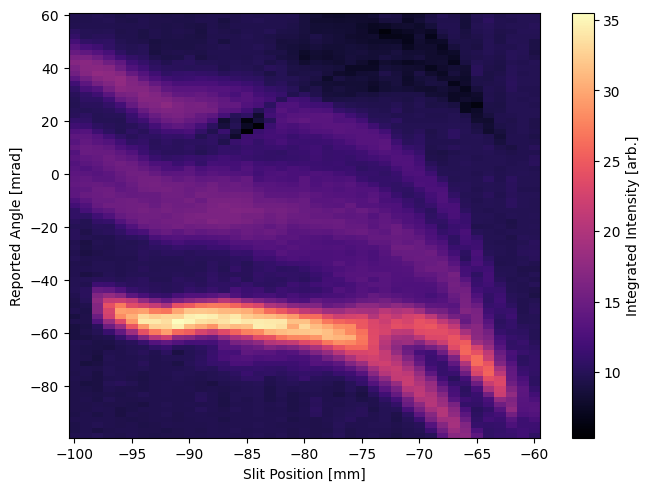

In [9]:
fig,ax = plt.subplots(layout="constrained")

x,y = np.meshgrid(posArr,relAng*1e3)
c = ax.pcolormesh(x,y,sumDat,cmap="magma")
ax.set_xlabel("Slit Position [mm]")
ax.set_ylabel("Reported Angle [mrad]")
fig.colorbar(c,label="Integrated Intensity [arb.]")
#plt.savefig("phaseSpace.svg",format="svg")

In [10]:
intensity = np.sum(np.sum(fullDat,axis=1),axis=1)

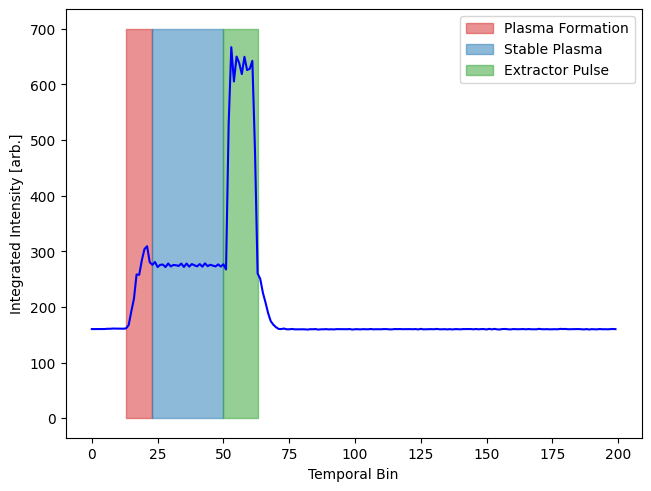

In [11]:
fig,ax = plt.subplots(layout="constrained")

t1 = 13
t2 = 23
t3 = 50
t4 = 63

ax.plot(intensity,c="b")
ax.set_xlabel("Temporal Bin")
ax.set_ylabel("Integrated Intensity [arb.]")
ax.fill_between((t1,t2),0,700,color="tab:red",alpha=0.5,zorder=-1,label="Plasma Formation")
ax.fill_between((t2,t3),0,700,color="tab:blue",alpha=0.5,zorder=-1,label="Stable Plasma")
ax.fill_between((t3,t4),0,700,color="tab:green",alpha=0.5,zorder=-1,label="Extractor Pulse")
ax.legend()
#plt.savefig("temporalSignalSpectrometer.svg",format="svg")

-0.17036153846153848 1.243576923076923


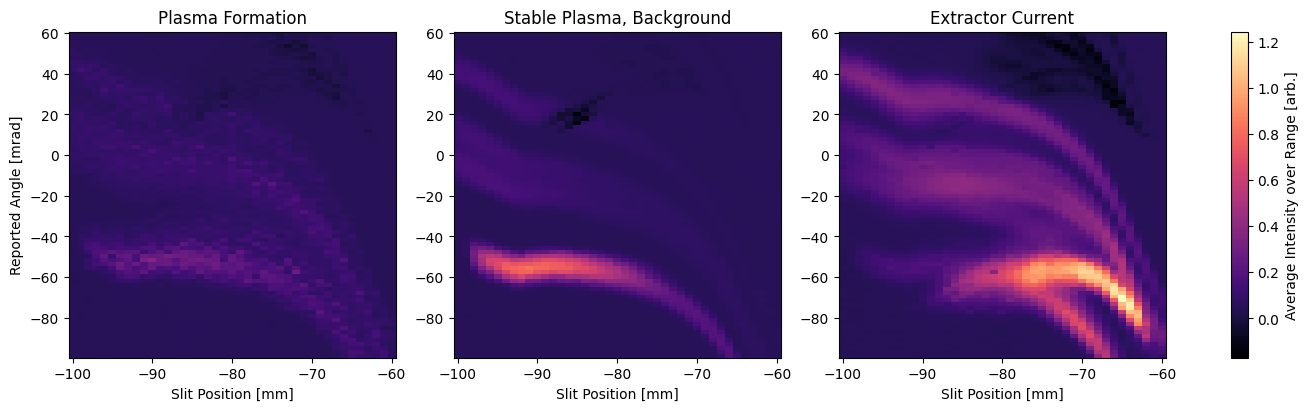

In [12]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

plasSum = np.sum(fullDat[t1:t2],axis=0)/(t2-t1)
shelfSum = np.sum(fullDat[t2:t3],axis=0)/(t3-t2)
extSum = np.sum(fullDat[t3:t4],axis=0)/(t4-t3)

minC = np.min((np.min(plasSum),np.min(shelfSum),np.min(extSum)))
maxC = np.max((np.max(plasSum),np.max(shelfSum),np.max(extSum)))
print(minC,maxC)

fig,ax = plt.subplots(ncols = 3,figsize=(13,4),layout="constrained")

cmap = plt.get_cmap("magma")
normalizer = Normalize(minC, maxC)
im = cm.ScalarMappable(cmap = cmap,norm=normalizer)

ax[0].pcolormesh(x,y,plasSum,cmap=cmap,norm=normalizer)
ax[0].set_ylabel("Reported Angle [mrad]")
ax[0].set_xlabel("Slit Position [mm]")
ax[0].set_title("Plasma Formation")

ax[1].pcolormesh(x,y,shelfSum,cmap=cmap,norm=normalizer)
ax[1].set_xlabel("Slit Position [mm]")
ax[1].set_title("Stable Plasma, Background")

ax[2].pcolormesh(x,y,extSum,cmap=cmap,norm=normalizer)
ax[2].set_xlabel("Slit Position [mm]")
ax[2].set_title("Extractor Current")

fig.colorbar(im,ax=ax.ravel().tolist(),label="Average Intensity over Range [arb.]")
#plt.savefig("temporalDistributionsBigSpectrometry.svg",format="svg")